In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import nltk
import re
from nltk.corpus import stopwords#, PlainTextCorpusReader
from nltk import word_tokenize, ngrams
from nltk.stem import WordNetLemmatizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch
from transformers import LlamaTokenizer
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings('ignore')

In [37]:
!pip install sentence_transformers

     -------------------------------------- 163.3/163.3 kB 4.8 MB/s eta 0:00:00


In [5]:
raw_data=pd.read_csv('text.csv')

In [6]:
class_to_emotion = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
raw_data['emotion'] = raw_data['label'].map(class_to_emotion)

category_counts = raw_data['emotion'].value_counts()

In [7]:
raw_data

,Unnamed: 0,text,label,emotion
0,0,i just feel really helpless and heavy hearted,4,fear
1,1,ive enjoyed being able to slouch about relax a...,0,sadness
2,2,i gave up my internship with the dmrg and am f...,4,fear
3,3,i dont know i feel so lost,0,sadness
4,4,i am a kindergarten teacher and i am thoroughl...,4,fear
...,...,...,...,...
416804,416804,i feel like telling these horny devils to find...,2,love
416805,416805,i began to realize that when i was feeling agi...,3,anger
416806,416806,i feel very curious be why previous early dawn...,5,surprise
416807,416807,i feel that becuase of the tyranical nature of...,3,anger


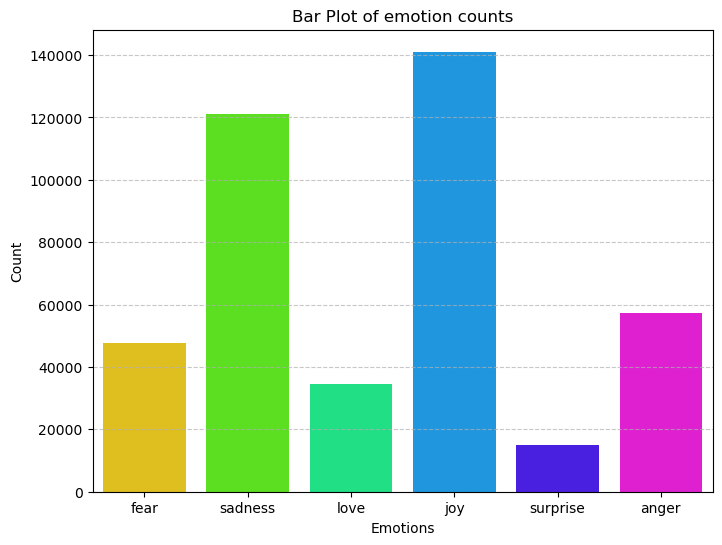

In [8]:
plt.figure(figsize=(8, 6))
#category_counts.plot(kind='bar')#, color='skyblue')  # Create the bar plot
plt.title('Bar Plot of emotion counts')
sns.countplot(data=raw_data, x='emotion', palette='hsv') 
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [9]:
raw_data.head()

,Unnamed: 0,text,label,emotion
0,0,i just feel really helpless and heavy hearted,4,fear
1,1,ive enjoyed being able to slouch about relax a...,0,sadness
2,2,i gave up my internship with the dmrg and am f...,4,fear
3,3,i dont know i feel so lost,0,sadness
4,4,i am a kindergarten teacher and i am thoroughl...,4,fear


In [10]:
raw_data.shape

(416809, 4)

In [11]:
data=raw_data[['text', 'label']]

In [12]:
data.groupby('label').count()

,text
label,
0,121187
1,141067
2,34554
3,57317
4,47712
5,14972


In [13]:
data['text'] = data['text'].astype(str)
data['text'] = data['text'].str.lower()
data['text'] = data['text'].str.replace('[^\w\s]','')

In [14]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mehdi.sadeghi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [15]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mehdi.sadeghi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mehdi.sadeghi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mehdi.sadeghi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
nrows=len(data)

lematized_text_list=[]
for row in range (0,nrows):
    lemmatized_list = []
    text = data.loc[row]['text']
    text_words = text.split(" ")
    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lematized_text_list.append(lemmatized_text)
    
data['text_lemmatized'] = lematized_text_list

In [19]:
def remove_stopwords(text):
    # Tokenize the text into words
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop]
    filtered_text = ' '.join(filtered_words)
    
    return filtered_text
data['text_WO_stopwords'] = data['text_lemmatized'].apply(remove_stopwords)

In [20]:
data.head()

,text,label,text_lemmatized,text_WO_stopwords
0,i just feel really helpless and heavy hearted,4,i just feel really helpless and heavy hearted,feel really helpless heavy hearted
1,ive enjoyed being able to slouch about relax a...,0,ive enjoy be able to slouch about relax and un...,ive enjoy able slouch relax unwind frankly nee...
2,i gave up my internship with the dmrg and am f...,4,i give up my internship with the dmrg and be f...,give internship dmrg feel distraught
3,i dont know i feel so lost,0,i dont know i feel so lose,dont know feel lose
4,i am a kindergarten teacher and i am thoroughl...,4,i be a kindergarten teacher and i be thoroughl...,kindergarten teacher thoroughly weary job take...


In [21]:
data.to_csv('./clean_text.csv')

# Data Embedding for LLM

Tried two different pre-trained embedding models with different sizes. The first one is the sentence-transformers/all-mpnet-base-v2 model. The second one is the paraprase-MiniLM-L6-v2 model. 
Mpnet-base-v2 is a 768 dimensional vectors while MiniLM-L6-v2 is a 384 dimensional vectors. AI ran Llama models on both embedding datasets. The Mpnet result were better comparing on accuracy.pnet more likely will result better.

In [22]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
device=torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [43]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')#'sentence-transformers/all_mpnet_base_v2')
device=torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [23]:
max_i=data.shape[0]
print(max_i)
batch_size=50000
num_batches=int(max_i/batch_size)
iloc_indexes=[x*batch_size for x in range(num_batches+1)]

416809


In [24]:
print(num_batches)

8


In [ ]:
encoded_text_df_list=[]
n=len(data)
for i in iloc_indexes:
    if i+batch_size>max_i:
        end_i=max_i
    else:
        end_i=i+batch_size
    text=data.iloc[i:end_i]['text_WO_stopwords'].values
    embeddings=model.encode(text)
    embedded_df=pd.DataFrame(embeddings)
    embedded_df.columns=['c_' + str(col) for col in embedded_df.columns]
    embedded_df['text_WO_stopwords'] = text
    embedded_df['text']=data.iloc[i:end_i]['text'].values
    embedded_df['label']=data.iloc[i:end_i]['label'].values
    encoded_text_df_list.append(embedded_df)
    r=1200000-(n%1000000)
    if ((i!=0) and (i%1000000==0)) or (i+batch_size>max_i):
        pd.concat(encoded_text_df_list, ignore_index=True).to_csv('embeddings/mpnet_embed_df_part'+str(i)+'.csv', index=False)
        #pd.concat(encoded_text_df_list, ignore_index=True).to_parquet('embeddings/mpnet_embed_pq.gzip', compression='gzip')
        print('the first part of data is done and saved')
       

## Data Partitioning

we use Stratified random partitioning as we are dealing with imbalanced dataset. This is a valuable technique for dividing a dataset into training, validation, and test sets while ensuring that each subset maintains the same class distribution as the original dataset. This approach is particularly beneficial when working with imbalanced datasets, where certain classes are less represented than others. By stratifying the partitions based on the target variable's classes, we can create subsets that accurately reflect the overall dataset's class proportions. This strategy helps in training models that generalize well across different classes and avoid biases towards the majority class.

In [61]:
embd_data=pd.read_csv('embeddings/mpnet_embed_df.csv')

In [67]:
X = embd_data.drop('label', axis=1)
y = embd_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

I have done data partitioning as part of the modeling notebook. therefore, I have not saved the partitioned data from here.